<a href="https://colab.research.google.com/github/aml-2023/assignment-3/blob/practice/Practice/AML_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of contents:
* Initial Setup
* Data Loading and Preprocessing
    * Data Variables
* Model Instantiation
* Optimizer and Scheduler
* Train and Evaluation Loop
    * Save the model and plot the losses (**1 Point**)
* Test Loop  
* Human Pose Visualization (**2 Points**)
* Report and Parameter Fine-Tuning Analysis  (**4 Points**)
* Calculating MPJPE for a Specific Frame  (**2 Points**)
* Iterative Mechanism (**3 Points**)
* YOUR custom model (**3 Points**)
    * Performance BONUS (**Up to 2 Points**)



## Initial Setup
Run the following two cellls to sync with Google Drive only if you run from Google Colab.

*Note: we recommend using Google Colab for this specific homework, since the training phase will require a GPU*

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# First Time Setup
If we are setting up the notebook for the first time, we need to
1. Move to root of your drive.
1. Create folder structure to hold the practice code and data, and move to the folder.
1. Download the `homework.zip` file.
1. Unpack the zip file and move everything from the practice folder.


In [2]:
# 1
%cd /content/drive/MyDrive

# 2
!mkdir -p aml-2023/homework-1/Practice/
%cd aml-2023/homework-1/Practice/

# 3
!wget -O homework-1.zip https://aml-2023.s3.eu-north-1.amazonaws.com/homework-1.zip
!unzip homework-1.zip -qq

# 4
!cp -r Homework_24/Practice/* .
!rm -rf Homework_24
!rm AML_practice.ipynb

/content/drive/MyDrive
/content/drive/MyDrive/aml-2023/homework-1/Practice
--2023-11-20 16:25:29--  https://aml-2023.s3.eu-north-1.amazonaws.com/homework-1.zip
Resolving aml-2023.s3.eu-north-1.amazonaws.com (aml-2023.s3.eu-north-1.amazonaws.com)... 16.12.9.2, 16.12.10.14
Connecting to aml-2023.s3.eu-north-1.amazonaws.com (aml-2023.s3.eu-north-1.amazonaws.com)|16.12.9.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140548792 (134M) [application/zip]
Saving to: ‘homework-1.zip’

homework-1.zip      100%[===================>] 134.04M  18.6MB/s    in 8.8s    

2023-11-20 16:25:39 (15.3 MB/s) - ‘homework-1.zip’ saved [140548792/140548792]

Archive:  homework-1.zip
caution: filename not matched:  -qq
cp: cannot stat 'Homework_24/Practice/*': No such file or directory
rm: cannot remove 'AML_practice.ipynb': No such file or directory


# Successive Times
If you have done the setup already, we just need to move into the dedicated practice folder.

In [3]:
%cd /content/drive/MyDrive/aml-2023/homework-1/Practice/

/content/drive/MyDrive/aml-2023/homework-1/Practice


Welcome to this guide on training, testing, and fine-tuning a deep learning model. Deep learning is at the forefront of artificial intelligence, with applications spanning image recognition, natural language processing, and more.

Throughout this assignment, you'll:

1. **Prepare Data:** Preprocess and load the data.

2. **Use Neural Networks:** Instantiate a neural network architecture.

3. **Train Models:** Utilize optimization, loss functions, and backpropagation.

4. **Evaluate Performance:** Assess model performance, prevent overfitting, and underfitting.

5. **Fine-Tune Models:** Explore hyperparameter tuning.

In [7]:
from utils import h36motion3d as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.autograd
import torch
import numpy as np
from utils.loss_funcs import *
from utils.data_utils import define_actions
from utils.h36_3d_viz import visualize
import time
import pandas as pd

import torch.nn.functional as F

In [8]:
# Use GPU if available, otherwise stick with cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device,  '- Type:', torch.cuda.get_device_name(0))

Using device: cuda - Type: Tesla T4


## Data Loading and Preprocessing

For this homework, you will use [Human3.6M](https://vision.imar.ro/human3.6m/pami-h36m.pdf), which is a large-scale dataset of 3.6 million accurate 3D human poses acquired by recording the performance of five female and six male subjects under four different viewpoints. The dataset includes:
- Synchronized image.
- Human motion capture.
- Time of flight (depth) data.
- Accurate 3D body scans of all the subject actors involved.

The dataset aims to provide diverse motions and poses encountered in typical human activities, with additional data to train realistic human sensing systems.

![picture](https://drive.google.com/uc?export=view&id=1nyD1_F3r1ctexKFGDmhy2Q9SX_2Z_bpS)

For this assignment, we will leverage the rich **motion data** (See in the figure above) provided by H3.6M to perform a task known as *motion prediction*. Motion prediction involves using historical motion data to forecast future movements. This task is fundamental in human-robot interaction, animation, and sports analytics applications.

### Data Variables

Each created sequence has the shape (35, 17, 3), where:
- Number of observed sequences and number of sequences to predict: $N_{obs}+N_{pred} = 10 + 25 = 35$;
- Number of body joints to consider: $J=22$;
- Spatial coordinates: $(x,y,z) = 3$.


The original data provides high-resolution progressive scan videos at 50 Hz. However, the dataset has been downsampled to 25 Hz for research purposes. This means that 25 frames of motion data are provided per second.

*Note: the figure above shows 18 joints, however the dataset contains 32. For this specific case we will consider 22 joints, ignoring some of the finer ones (e.g. foot tip, hand tip, etc)*


In [9]:
# # Arguments to setup the datasets
datas = 'h36m' # dataset name
path = './data/h3.6m/h3.6m/dataset'
input_n=10 # number of frames to train on (default=10)
output_n=25 # number of frames to predict on
input_dim=3 # dimensions of the input coordinates(default=3)
skip_rate=1 # # skip rate of frames
joints_to_consider=22


#FLAGS FOR THE TRAINING
mode='train' #choose either train or test mode

batch_size_test=8
model_path= './checkpoints/' # path to the model checkpoint file

actions_to_consider_test='all' # actions to test on.
model_name = datas+'_3d_'+str(output_n)+'frames_ckpt' #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz='all' # actions to visualize
visualize_from='test'
n_viz=2

Load Dataset

*Note: It will take you ~ 5 minutes*

In [10]:
# Load Data
print('Loading Train Dataset...')
dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=0)
print('Loading Validation Dataset...')
vald_dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=1)

#! Note: Ignore warning:  "VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences"

Loading Train Dataset...


/content/drive/MyDrive/aml-2023/homework-1/Practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


Loading Validation Dataset...


Following we create a torch dataloader that create the batches for each epoch.

In [11]:
batch_size=256

print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)#

print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

>>> Training dataset length: 180077
>>> Validation dataset length: 28110


## Model instantiation


Each sequence comprises an **observed** part to train the Encoder and a part that attempts to predict the **future** sequence, the Decoder.

Generally, the standard setup plans to use the first 10 sequences of poses ($N_{obs}=10$) for the observation and the following 25 ($N_{pred} = 25$) for the prediction.


We create an instance of a custom Spatio-Temporal transformer with the chosen configuration.

(*Note: explore the model in ./models/sttr/sttformer.py*)

Then we allocate it to the GPU for forward and backward accelerated computation.

In [ ]:
from models.sttr.sttformer import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

n_heads = 1

model = Model(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                 num_channels=3, kernel_size=[3,3], use_pes=True).to(device)

print('total number of parameters of the network is: '+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Using device: cuda
total number of parameters of the network is: 26859


## Optimizer and Scheduler

As we embark on training deep learning models for motion prediction using the H3.6M dataset, it's essential to recognize several key parameters and components that significantly impact the training phase:

- **Learning Rate:** This parameter determines the convergence speed during optimization.

- **Batch Size:** It influences model generalization and training efficiency.

- **Number of Epochs:** The number of training iterations affects model learning.

- **Loss Function:** The choice of loss function directly affects learning and final performance.

- **Optimizer:** The optimization algorithm used (e.g., Adam, SGD) impacts gradient descent during training.

- **Milestones and Gamma:** These parameters control learning rate schedules, allowing for adaptive adjustments during training.

- **Weight Decay:** It regulates the impact of model parameters during optimization.

- **Scheduler:** Scheduler strategies (e.g., StepLR, ReduceLROnPlateau) manage learning rate adaptation during training.

In [30]:
# Arguments to setup the optimizer
lr=1e-01 # learning rate
use_scheduler=True # use MultiStepLR scheduler
milestones=[10,30]   # the epochs after which the learning rate is adjusted by gamma
gamma=0.1 #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay=1e-05 # weight decay (L2 penalty)
optimizer=optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [31]:
clip_grad=None # select max norm to clip gradients
# Argument for training
n_epochs=41
log_step = 200

## Train and Evaluation Loop

The **loss** and **metric** used during training and evaluation respectively, compare the predicted joint positions to ground truth joint positions for all frames, which is typically referred to as the **Average Mean Per
Joint Position Error (A-MPJPE)** can be seen as an $L_2$. This loss quantifies the dissimilarity between the predicted and ground truth joint positions by measuring the squared Euclidean distance between corresponding joint positions.

\begin{align*}
A-MPJPE &= \frac{1}{N_{pred}} \sum_{i=1}^{N_{pred}} \left(\frac{1}{J} \sum_{j=1}^{J} \left\| P_{\text{predicted}_{t,j}} - P_{\text{gt}_{t,j}} \right\|^2\right)
\end{align*}

$$where:$$

\begin{align*}
P_{\text{predicted}} &: \text{Set of predicted joint positions estimated by the model.} \\
P_{\text{gt}} &: \text{Corresponding set of ground truth joint positions.} \\
\end{align*}

*Note: If you restart the training for any reason, remember to instantiate the model and the optimizer again. This will avoid continuing the training with the initialized weights of the previous one*


### Save the model and plot the losses (1 Point)

**Objective:** In this exercise, you will practice implementing a code snippet to save your deep learning model's checkpoints and visualize the training and validation loss on the same plot every 5 epochs during model training.

Your task is to implement the following:

- Set up a mechanism to save the model's checkpoints (weights and architecture) during training. These checkpoints should be saved periodically, say, **every 5 epochs**.

- Create a plot displaying the training and validation losses on the same graph. The x-axis should represent the number of epochs, and the y-axis should represent the loss values. The training and validation losses should be plotted as separate lines on the same graph.

- Ensure that the code saves the model's checkpoints in a specified directory, including the model's architecture and weights, and that the loss plot is displayed.

Analyze the loss plot to gain insights into how your model is learning over time and whether there are any signs of overfitting or underfitting.

*Note: see the Pytorch Documentation on how to save your model's checkpoints.*


In [ ]:
def train(data_loader,vald_loader, path_to_save_model=None):
  train_loss = []
  val_loss = []
  val_loss_best = 1000

  dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                    46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                    75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

  for epoch in range(n_epochs-1):
      running_loss=0
      n=0
      model.train()
      for cnt,batch in enumerate(data_loader):
          batch=batch.float().to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt = batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

          optimizer.zero_grad()
          sequences_predict = model(sequences_train).view(-1, output_n, joints_to_consider, 3)

          loss = mpjpe_error(sequences_predict,sequences_gt)

          if cnt % log_step == 0:
            print('[Epoch: %d, Iteration: %5d]  training loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))

          loss.backward()
          if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(),clip_grad)

          optimizer.step()
          running_loss += loss*batch_dim

      train_loss.append(running_loss.detach().cpu()/n)

      model.eval()

      with torch.no_grad():
          running_loss=0
          n=0
          for cnt,batch in enumerate(vald_loader):
              batch=batch.float().to(device)
              batch_dim=batch.shape[0]
              n+=batch_dim


              sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
              sequences_gt=batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

              sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
              loss = mpjpe_error(sequences_predict,sequences_gt)

              if cnt % log_step == 0:
                        print('[Epoch: %d, Iteration: %5d]  validation loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))

              running_loss += loss*batch_dim

          val_loss.append(running_loss.detach().cpu()/n)

          if running_loss/n < val_loss_best:
            val_loss_best = running_loss/n

      if use_scheduler:
        scheduler.step()

      '''
      Insert your code below. Use the argument path_to_save_model to save the model to the path specified.
      '''

      def plot_loss(train_loss, val_loss):
        """Plots the training and validation loss curves of the model.

        The loss curves will be plotted in the same plot, with a legend annotating the curves.
        The epochs axis will start from 0, not 1 like the print statements in the loop.

        :arg
          train_loss (iterable): the per epoch training loss of the model.
          val_loss (iterable): the per epoch validation loss of the model.
        """
        plt.xlabel("Epoch")
        plt.ylabel("Average Mean Per Joint Position Loss")
        plt.title("Train and Validation Loss of Joint Position Model")
        plt.plot(train_loss, label="Train")
        plt.plot(val_loss, label="Val")
        plt.legend()
        plt.show()

      # save and plot model every 5 epochs
      # epoch + 1 so that we don't print after the first epoch and also save and plot after the last epoch
      if save_and_plot:
        if (epoch + 1) % 5 == 0 or (epoch == n_epochs - 2):
            full_param_path = f"{path_to_save_model}model_params_epoch_{epoch}.pt"

            # saves and loads only the model parameters:
            torch.save(model.state_dict(), full_param_path)
            print(f"Model saved at: {full_param_path}")

            # plot
            plot_loss(train_loss, val_loss)

[Epoch: 1, Iteration:     1]  training loss: 561.889
[Epoch: 1, Iteration:   201]  training loss: 130.363
[Epoch: 1, Iteration:   401]  training loss: 113.580
[Epoch: 1, Iteration:   601]  training loss: 113.654
[Epoch: 1, Iteration:     1]  validation loss: 106.159
[Epoch: 2, Iteration:     1]  training loss: 102.734
[Epoch: 2, Iteration:   201]  training loss: 104.020
[Epoch: 2, Iteration:   401]  training loss: 103.146
[Epoch: 2, Iteration:   601]  training loss: 108.031
[Epoch: 2, Iteration:     1]  validation loss: 91.245
[Epoch: 3, Iteration:     1]  training loss: 99.632
[Epoch: 3, Iteration:   201]  training loss: 93.412
[Epoch: 3, Iteration:   401]  training loss: 98.566
[Epoch: 3, Iteration:   601]  training loss: 91.175
[Epoch: 3, Iteration:     1]  validation loss: 89.943
[Epoch: 4, Iteration:     1]  training loss: 96.164
[Epoch: 4, Iteration:   201]  training loss: 91.605
[Epoch: 4, Iteration:   401]  training loss: 94.977
[Epoch: 4, Iteration:   601]  training loss: 93.8

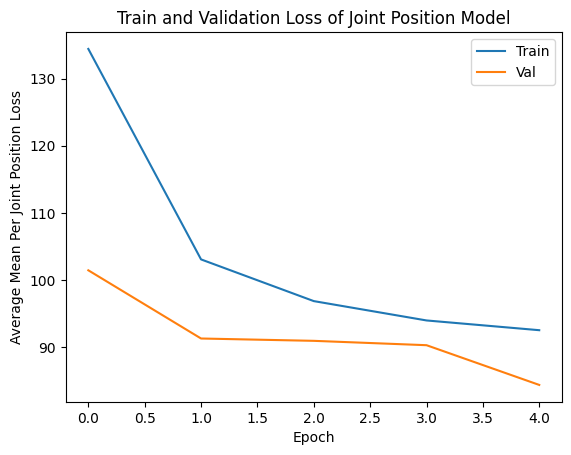

[Epoch: 6, Iteration:     1]  training loss: 89.571
[Epoch: 6, Iteration:   201]  training loss: 87.845
[Epoch: 6, Iteration:   401]  training loss: 91.114
[Epoch: 6, Iteration:   601]  training loss: 90.139
[Epoch: 6, Iteration:     1]  validation loss: 89.008
[Epoch: 7, Iteration:     1]  training loss: 87.539
[Epoch: 7, Iteration:   201]  training loss: 88.172
[Epoch: 7, Iteration:   401]  training loss: 85.325
[Epoch: 7, Iteration:   601]  training loss: 88.425
[Epoch: 7, Iteration:     1]  validation loss: 88.742
[Epoch: 8, Iteration:     1]  training loss: 87.288
[Epoch: 8, Iteration:   201]  training loss: 89.095
[Epoch: 8, Iteration:   401]  training loss: 87.656
[Epoch: 8, Iteration:   601]  training loss: 88.961
[Epoch: 8, Iteration:     1]  validation loss: 89.793
[Epoch: 9, Iteration:     1]  training loss: 87.566
[Epoch: 9, Iteration:   201]  training loss: 89.135
[Epoch: 9, Iteration:   401]  training loss: 86.021
[Epoch: 9, Iteration:   601]  training loss: 86.533
[Epoch

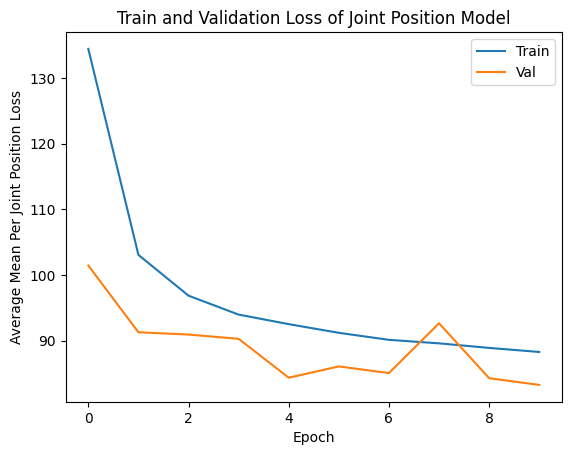

[Epoch: 11, Iteration:     1]  training loss: 88.443
[Epoch: 11, Iteration:   201]  training loss: 84.734
[Epoch: 11, Iteration:   401]  training loss: 84.606
[Epoch: 11, Iteration:   601]  training loss: 83.948
[Epoch: 11, Iteration:     1]  validation loss: 79.184
[Epoch: 12, Iteration:     1]  training loss: 90.695


KeyboardInterrupt: ignored

In [ ]:
save_and_plot = True # save the model and plot the loss. Change to True if you want to save the model and plot the loss

# launch training
train(data_loader,vald_loader, path_to_save_model=model_path)

## Test Loop

After training and validation, the test loop is the final phase that evaluates the model's performance on an entirely independent dataset known as the test dataset. This dataset is distinct from the training and validation data, ensuring unbiased assessment. The test loop provides a reliable estimate of how well the model will perform in real-world scenarios, confirming that any improvements observed during training and validation are not due to overfitting or chance. It's a crucial step before deploying the model in practical applications.

In [ ]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print(f'model loaded from {ckpt_path}')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim


          all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, :]


          running_time = time.time()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
          #sequences_predict = model(sequences_train)
          totalll += time.time()-running_time
          counter += 1
          sequences_predict=sequences_predict.contiguous().view(-1,output_n,len(dim_used))

          all_joints_seq[:,:,dim_used] = sequences_predict

          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss=mpjpe_error(all_joints_seq.view(-1,output_n,32,3),sequences_gt.view(-1,output_n,32,3))
          running_loss+=loss*batch_dim
          accum_loss+=loss*batch_dim

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches+=n
    print('Average: '+str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)


*Note: Your results should be better than 95 millimiters on average*

In [ ]:
ckpt_path = './checkpoints/model_params_epoch_39.pt' # Change the epoch according to the validation curve
test(ckpt_path)

model loaded from ./checkpoints/model_params_epoch_39.pt


/content/drive/MyDrive/aml-2023/homework-1/Practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


walking :  59.3
eating :  57.9
smoking :  59.9
discussion :  87.3
directions :  77.6
greeting :  100.2
phoning :  74.9
posing :  114.2
purchases :  100.1
sitting :  86.8
sittingdown :  111.9
takingphoto :  85.4
waiting :  80.7
walkingdog :  109.4
walkingtogether :  58.3
Average: 84.3
Prediction time:  0.017696938415368398


## Human Pose Visualization  (**2 Points**)

The qualitative results are as important as the quantitative ones. In this section, you will visualize and compare the predicted poses with the ground truth ones.
For simplicity, you will visualize only the first predicted pose and the ground truth.

Ideally, the same plot should show the predicted pose in red and the ground truth one in green.

*Note: you will find which nodes are connected in the file ./models/skeleton_connection.py*

In [ ]:
def first_pose(model_state_dict_path: str):
    """Gets the first predicted and ground truth pose from the test data.

    Loads the model from the given path and does the prediction.

    :arg
    model_state_dict_path (str): the full path to the state dict of the model for which to obtain the first prediction and ground truth pair.
    :return
    ()
    """
    model.load_state_dict(torch.load(model_state_dict_path))
    print(f'model loaded from: {model_state_dict_path}')

    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                    46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                    75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0

    for action in actions:
        running_loss=0
        n=0
        dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])

        test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
        for cnt, batch in enumerate(test_loader):
            with torch.no_grad():

                batch = batch.to(device)
                batch_dim = batch.shape[0]
                n += batch_dim

                all_joints_seq_predict = batch.clone()[:, input_n:input_n+output_n,:]

                sequences_train = batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
                sequences_gt = batch[:, input_n:input_n+output_n, :]

                running_time = time.time()
                sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)

                totalll += time.time()-running_time
                counter += 1
                sequences_predict=sequences_predict.contiguous().view(-1,output_n,len(dim_used))

                all_joints_seq_predict[:,:,dim_used] = sequences_predict
                all_joints_seq_predict[:,:,index_to_ignore] = all_joints_seq_predict[:,:,index_to_equal]

                # the dimensions are (batch, frame, joint, xyz coord) so we return the first frame of the first batch
                return all_joints_seq_predict[0, 0].reshape(32, 3), sequences_gt[0, 0].reshape(32, 3)

In [ ]:
pred, truth = first_pose(ckpt_path)

model loaded from: ./checkpoints/model_params_epoch_39.pt


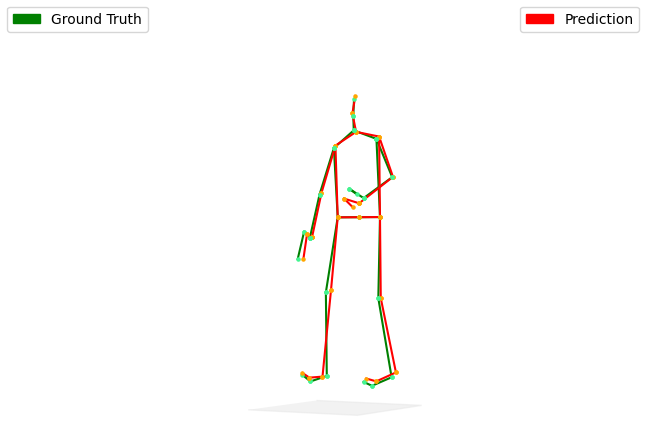

In [ ]:
import matplotlib.patches
from utils import skeleton_connections

def plot_skeleton(joints, fig=None, ax=None, **kwargs):
    """Plots the provided joints in a 3D space and returns the figure and axes object.

    Joints will be represented with circles and connected with straight lines. If a fig and ax object are provided, the joints will be plotted on it.

    :arg
        joints (torch.Tensor): a torch tensor of shape (j, d) where j are the joints and d are the 3 spatial dimensions.
        fig (plt.Figure): a pyplot figure on which to plot the joints.
        ax (plt.Axes): pyplot axes on which to plot the joints.

    :return
        fig, ax: a figure and axis object with the plotted joints.
    """
    if not fig:
        fig = plt.figure()

    if not ax:
        ax = fig.add_subplot(111, projection='3d')

    joint_line_colour = kwargs.get("joint_line_colour", "r")
    joint_colour = kwargs.get("joint_colour", "orange")

  # tells me which joints to connect, I need to take the indeces and draw lines between in the space
    for joint_1, joint_2 in skeleton_connections.connect:
        x1, y1, z1 = joints[joint_1].cpu()
        x2, y2, z2 = joints[joint_2].cpu()

        ax.plot((x1, x2), (y1, y2), (z1, z2), c=joint_line_colour)

        ax.scatter(x1, y1, z1, c=joint_colour, marker='o', s=5)
        ax.scatter(x2, y2, z2, c=joint_colour, marker='o', s=5)

        ax.view_init(elev=60, azim=0, roll=90)
        # Get rid of the ticks and tick labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.set_zticklabels([])
    ax.set_aspect('equal')

    # Get rid of the panes (actually, make them white)
    white = (1.0, 1.0, 1.0, 0.0)
    ax.xaxis.set_pane_color(white)
    #ax.yaxis.set_pane_color(white)
    ax.zaxis.set_pane_color(white)

    # Get rid of the lines in 3d
    ax.xaxis.line.set_color(white)
    ax.yaxis.line.set_color(white)
    ax.zaxis.line.set_color(white)

    # manually define a new patch
    patch_label = matplotlib.patches.Patch(color=joint_line_colour, label=kwargs.get("label", ""))

    handles, labels = ax.get_legend_handles_labels()

    # remove
    handles = handles[len(skeleton_connections.connect)*2:]
    handles.append(patch_label)

    # plot the legend
    fig.legend(handles=handles, loc=kwargs.get("loc", "upper center"))

    return fig, ax

fig, ax = plot_skeleton(truth, joint_line_colour="g", joint_colour="#42f590", label="Ground Truth", loc="upper left")
fig, ax = plot_skeleton(pred, fig=fig, ax=ax, joint_line_colour="r", joint_colour="orange", label="Prediction", loc="upper right")

## Report and Parameter Fine-Tuning Analysis  (**4 Points**)

**Objective:** In this exercise, you will analyze the results obtained from a deep learning model you previously trained and perform parameter fine-tuning to optimize its performance. The key considerations are learning rate, milestones, and weight decay. **You will also use tables and plots to visualize and interpret the outcomes.**

**Instructions:**

1. **Analysis:** Analyze the generated report and answer the following questions:
   - Is there evidence of overfitting or underfitting in the initial training results?
   - Are there fluctuations in training and validation loss or accuracy? If so, what might be causing them?
   - What can you infer from the initial learning rate, milestones, and weight decay settings?

2. **Parameter Fine-Tuning:** Based on your analysis, perform parameter fine-tuning to optimize model performance. Adjust the following parameters:
   - **Learning Rate:** Experiment with different learning rates (higher and lower values) to find an optimal rate.
   - **Milestones:** Modify the milestone values for adjusting the learning rate schedule.
   - **Weight Decay:** Explore different weight decay values.
   

3. **Re-Training:** Train the model with the adjusted hyperparameters. Record the training progress and generate a new report, including performance metrics and line plots as before.

4. **Final Analysis:** Analyze the results of the fine-tuned model and compare them with the initial training. Answer the following questions:
   - Has parameter fine-tuning improved model performance?
   - Did it mitigate overfitting or underfitting issues?
   - What can you conclude about the optimal hyperparameters for this task?


##1. Analysis
From the plot it's possible to notice that the trends, of both the Train and Validation loss, show that the model is training and no overfitting should have occured. In fact, opposing to what we would have seen in case of overfitting -- the traing loss going down while the validation one starting to go back up from one point on -- in the plot is clear that both the curves are decreasing. At the same time the plot doesn't show signs of underfitting, after some inital variability in the validation line, both the curves seem to decrease rapidly during the first $10$ epochs and starting to stabilize around $30^{th}$ epoch.

## 2. Parameter Fine Tuning
We will do a grid search over the learning rate, milestones, and weight decay hyperparameters, by exploring an additional **lower** and **higher** value to the provided default values. This means that we will try a total of

$$3 \times 3 \times 3 = 27$$

different hyperparameter combinations.

In [ ]:
from os import listdir
from typing import List
from itertools import product

# learning rates we want to try, from 10^-3 to 10^1, the given default is in the middle
learning_rates = np.logspace(-2, 0, 3)

# epochs after which to lower the learning rate, go from infrequent lowering to frequent lowering
ft_milestones = [[30], [10, 30], [milestone for milestone in range(5, n_epochs, 5)]]

# weight decays, from low to high in factors of 10 with the default in the middle
weight_decays = np.logspace(-7, -3, 3)

# create a grid with all possible parameter combinations
parameter_grid = list(product(learning_rates, ft_milestones, weight_decays))

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingResults:
    """Dataclass for holding the training results from the parameter fine tuning."""
    learning_rate: float
    milestones: List
    weight_decay: float
    n_epochs: int
    train_loss: List
    val_loss: List

In [ ]:
def train_params(data_loader, vald_loader, save_and_plot=False, path_to_save_model=None, learning_rate=lr, n_epochs=n_epochs, milestones=milestones, weight_decay=weight_decay):
    """Training function that does not use global parameters like the original provided one and returns the training and validation loss.

    :arg
        data_loader: a pytorch data loader for the training data.
        vald_loader: a pytorch data loader for the validation data.
        save_and_plot (bool): if True, plots the train and val loss every 5 epochs and saves the model parameters.
        path_to_save_model (str): the path to where to save the model.
        learning_rate (float): the learning rate of the model.
        epochs (int): the number of epochs to train the model for.
        milestones (List[int]): a list of integers, specifying the epochs at which to lower the learning rate.
        weight_decay (float): the weight decay for the model.

    :return
        (TrainingResults): the training results with the parameters used for the training.
    """
    model = Model(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                 num_channels=3, kernel_size=[3,3], use_pes=True).to(device)

    optimizer=optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    if use_scheduler:
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    train_loss = []
    val_loss = []
    val_loss_best = 1000

    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                        26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                        46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                        75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

    for epoch in range(n_epochs-1):
        running_loss=0
        n=0
        model.train()
        for cnt,batch in enumerate(data_loader):
            batch=batch.float().to(device)
            batch_dim=batch.shape[0]
            n+=batch_dim

            sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
            sequences_gt = batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

            optimizer.zero_grad()
            sequences_predict = model(sequences_train).view(-1, output_n, joints_to_consider, 3)

            loss = mpjpe_error(sequences_predict,sequences_gt)

            if cnt % log_step == 0:
                print('[Epoch: %d, Iteration: %5d]  training loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))

            loss.backward()
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(),clip_grad)

            optimizer.step()
            running_loss += loss*batch_dim

        train_loss.append(running_loss.detach().cpu()/n)

        model.eval()

        with torch.no_grad():
            running_loss=0
            n=0
            for cnt,batch in enumerate(vald_loader):
                batch=batch.float().to(device)
                batch_dim=batch.shape[0]
                n+=batch_dim


                sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
                sequences_gt=batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

                sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
                loss = mpjpe_error(sequences_predict,sequences_gt)

                if cnt % log_step == 0:
                            print('[Epoch: %d, Iteration: %5d]  validation loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))

                running_loss += loss*batch_dim

            val_loss.append(running_loss.detach().cpu()/n)

            if running_loss/n < val_loss_best:
                val_loss_best = running_loss/n

        if use_scheduler:
            scheduler.step()

        '''
        Insert your code below. Use the argument path_to_save_model to save the model to the path specified.
        '''

        def plot_loss(train_loss, val_loss):
            """Plots the training and validation loss curves of the model.

            The loss curves will be plotted in the same plot, with a legend annotating the curves.
            The epochs axis will start from 0, not 1 like the print statements in the loop.

            :arg
            train_loss (iterable): the per epoch training loss of the model.
            val_loss (iterable): the per epoch validation loss of the model.
            """
            plt.xlabel("Epoch")
            plt.ylabel("Average Mean Per Joint Position Loss")
            plt.title("Train and Validation Loss of Joint Position Model")
            plt.plot(train_loss, label="Train")
            plt.plot(val_loss, label="Val")
            plt.legend()
            plt.show()

        # save and plot model every 5 epochs
        # epoch + 1 so that we don't print after the first epoch
        # also save and plot after the last epoch
        if save_and_plot:
            if (epoch + 1) % 5 == 0 or (epoch == n_epochs - 2):
                full_param_path = f"{path_to_save_model}model_params_epoch_{epoch}.pt"

                # saves and loads only the model parameters:
                torch.save(model.state_dict(), full_param_path)
                print(f"Model saved at: {full_param_path}")

                # plot
                plot_loss(train_loss, val_loss)

    return TrainingResults(learning_rate, milestones, weight_decay, n_epochs, train_loss, val_loss)

Since the parameter fine tuning will take some time, we will intermittently save the results in the google drive. Here, we create the directory in which to save the results.

In [ ]:
from pathlib import Path

results = []
result_path = "fine_tuning_results/"
Path(result_path).mkdir(parents=True, exist_ok=True)

The loop below, we loop over each of the 27 hyperparameter combinations, train the model on them and save the training and validation loss at each iteration.

**ATTENTION!!!** the model will only be trained if no saved file currently exists for it. If you want to the loop to recognise results, you need to place them inside the _fine_tuning_results/_ directory.

In [ ]:
from tqdm import tqdm
import os

for i, params in tqdm(enumerate(parameter_grid)):
    learning_rate, milestone, weight_decay = params
    file_name = f"{result_path}fine_tuning_results_{i}.pkl"
    if os.path.exists(file_name):
        continue

    result = train_params(data_loader, vald_loader, save_and_plot=False, learning_rate=learning_rate, milestones=milestone, weight_decay=weight_decay, n_epochs=41)

    with open(file_name, "wb") as file:
        pickle.dump(result, file)

    results.append(result)

27it [00:00, 4922.46it/s]


Once we have done the parameter tuning, we want to load the results back into memory again.

In [ ]:
import glob
import pickle

def load_fine_tuning_results(directory_path: str):
    """Loads the fine tuning results from the provided directory path.

    :arg
        directory_path (str): the path to the directory with .pkl files containing fine tuning objects.

    :return
        (List[TrainingResults]): a list of training result objects from the fine tuning tests.
    """
    files_to_load = glob.glob(f"{directory_path}*")

    training_results = []
    for file in files_to_load:
        with open(file, "rb") as f:
            training_results.append(pickle.load(f))

    return training_results

In [ ]:
fine_tuning_results = load_fine_tuning_results(result_path)

And then turn the objects into a pandas dataframe to make them easier to handle.

In [ ]:
def training_results_to_pandas(training_results):
    """Converts a list of training result objects into a pandas dataframe."""

    cols = ["learning_rate", "weight_decay", "n_epochs", "milestones", "train_loss", "val_loss"]
    results_df = pd.DataFrame(columns=cols)

    for result in training_results:
        num_rows = result.n_epochs
        learning_rate, weight_decay, n_epochs = [result.learning_rate] * num_rows, [result.weight_decay] * num_rows, range(result.n_epochs)
        milestones = [tuple(result.milestones)] * num_rows

        train_loss, val_loss = torch.stack(result.train_loss).tolist(), torch.stack(result.val_loss).tolist()
        df = pd.DataFrame(zip(learning_rate, weight_decay, n_epochs, milestones, train_loss, val_loss), columns=cols)

        results_df = pd.concat((results_df, df))

    return results_df

In [ ]:
results_df = training_results_to_pandas(fine_tuning_results)

Finally, we can plot the training and validation curves for each of the 27 hyperparameter combinations.

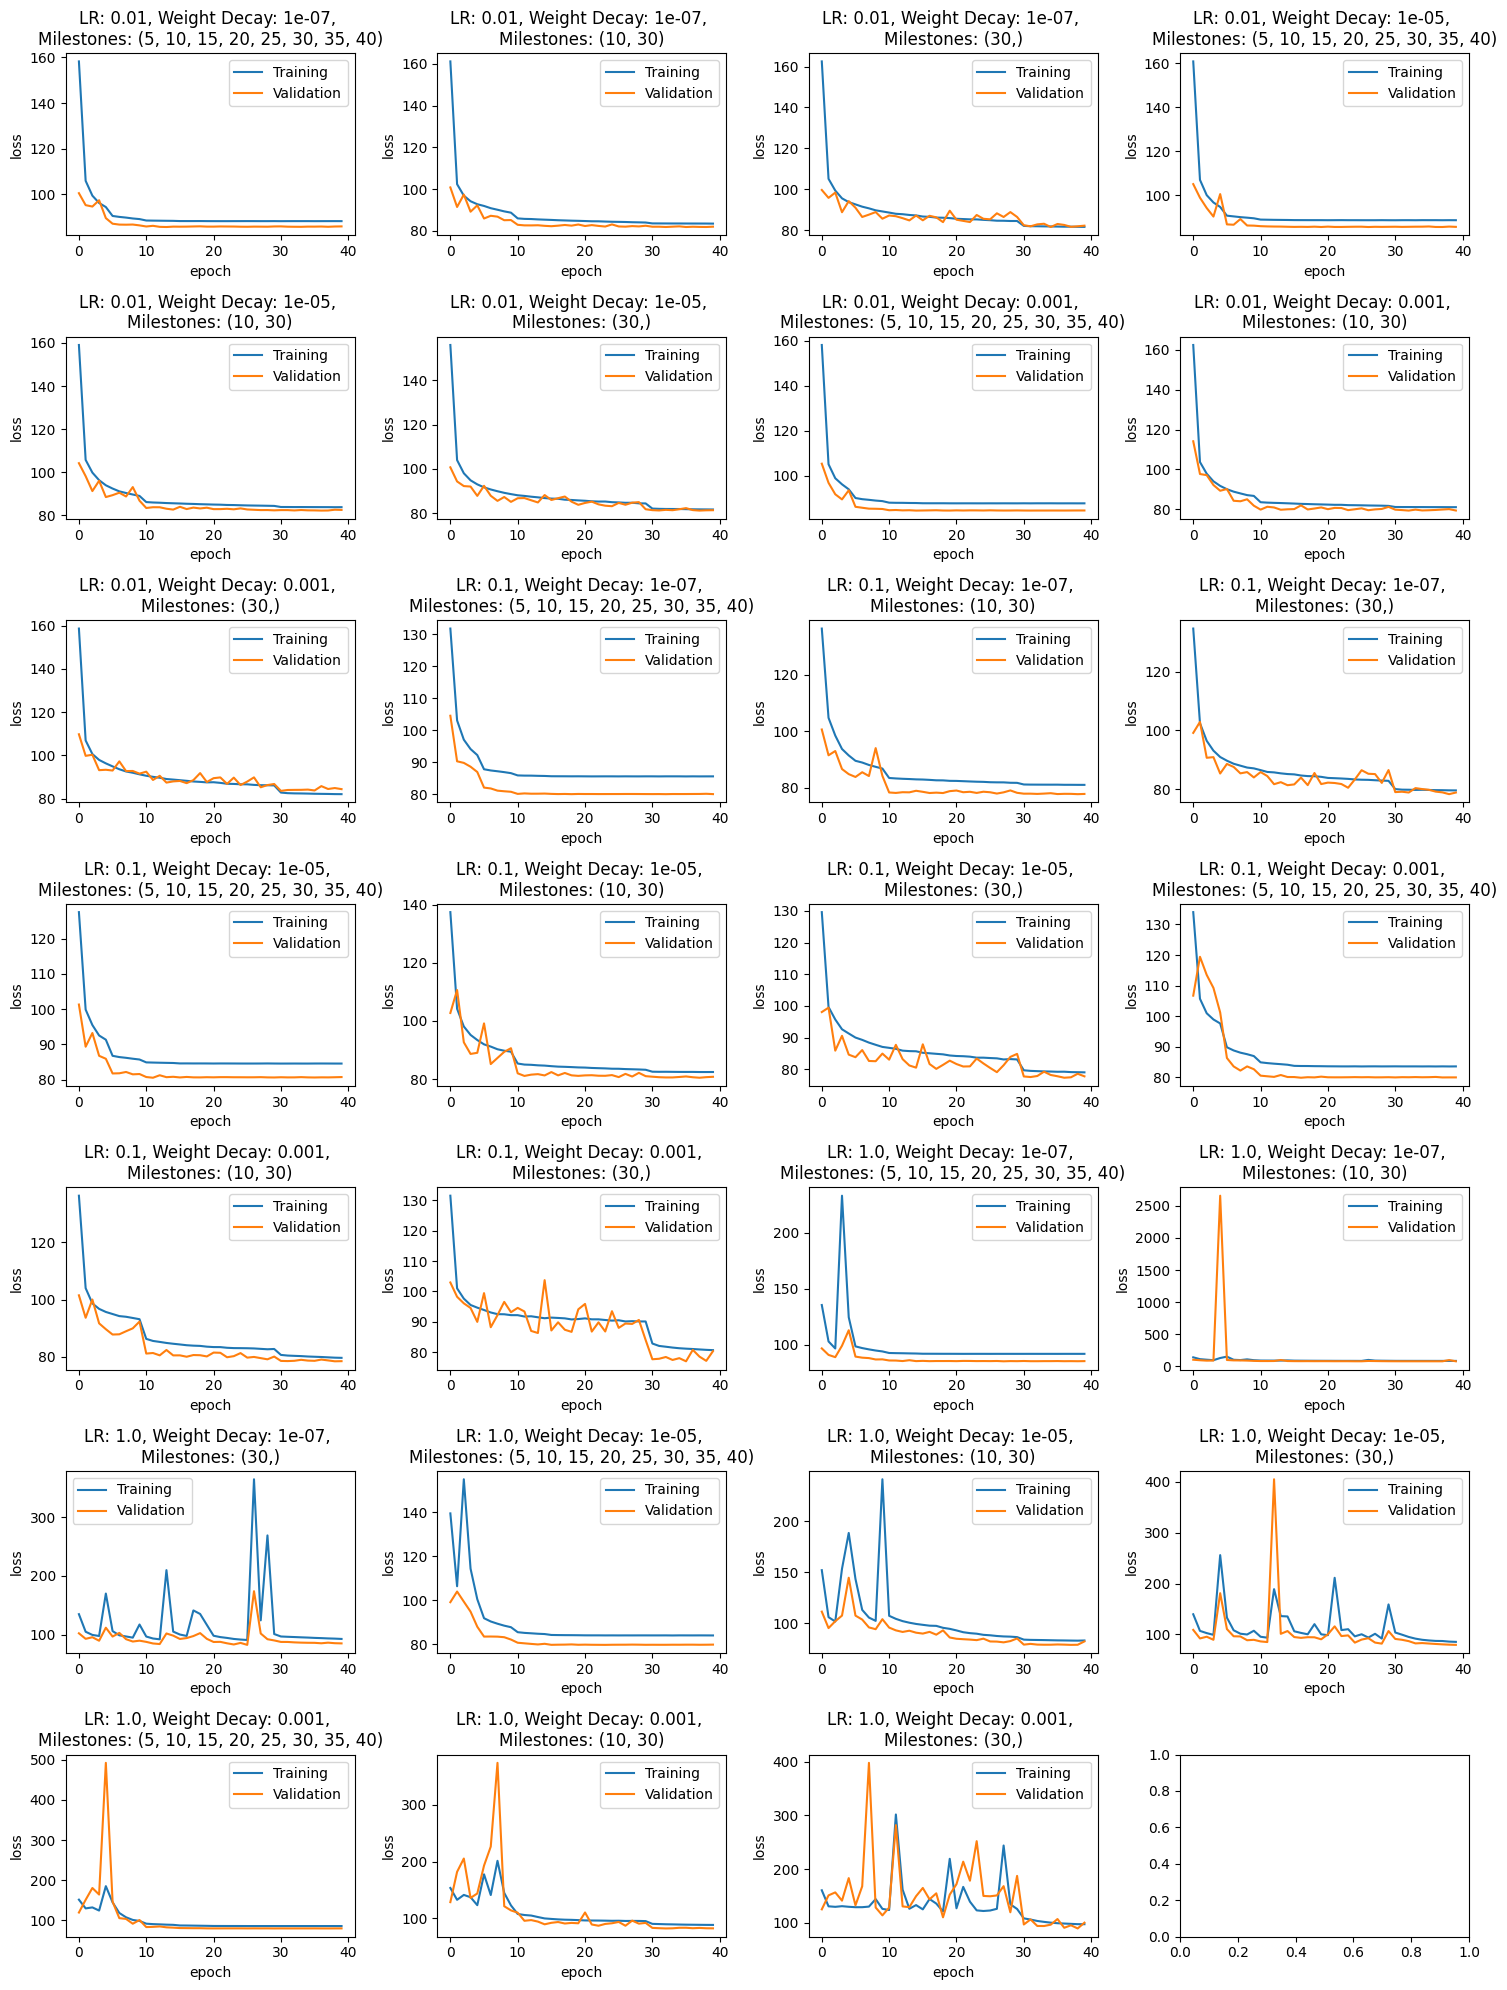

In [ ]:
grouped = results_df.groupby(["learning_rate", "weight_decay", "milestones"])

fig, axes = plt.subplots(7, 4, figsize=(15, 20))

for k_g, ax in zip(grouped, axes.flatten()):
    k, g = k_g

    learning_rate, weight_decay, milestones = g.learning_rate[0], g.weight_decay[0], g.milestones[0]
    ax.plot(g.n_epochs, g.train_loss, label="Training")
    ax.plot(g.n_epochs, g.val_loss, label="Validation")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.legend()
    ax.set_title(f"LR: {learning_rate}, Weight Decay: {weight_decay}, \nMilestones: {milestones}")

fig.tight_layout()

We can find the best hyperparameter combination by picking the one with the **lowest** validation loss.

In [ ]:
lowest_val_loss = results_df[results_df.val_loss == results_df.val_loss.min()]
display(lowest_val_loss)

,learning_rate,weight_decay,n_epochs,milestones,train_loss,val_loss
35,0.1,0.001,35,"(30,)",81.191933,77.037628


## 3. **Re-Training:**
Lets retrain the model using these new parameters.

In [ ]:
ft_learning_rate, ft_weight_decay, ft_milestones = lowest_val_loss.learning_rate.item(), lowest_val_loss.weight_decay.item(), lowest_val_loss.milestones.item()

path_to_save_model = "re_training_models/"
Path(path_to_save_model).mkdir(exist_ok=True, parents=True)
train_params(data_loader, vald_loader, save_and_plot=True, path_to_save_model=path_to_save_model, learning_rate=ft_learning_rate, milestones=ft_milestones, weight_decay=ft_weight_decay, n_epochs=n_epochs)

[Epoch: 1, Iteration:     1]  training loss: 561.676


KeyboardInterrupt: ignored

##4. Final Analysis
After performing the hyperparameter fine-tuning, we noticed that the new model had a slightly higher train loss and a bit lower validation loss than the first model we trained. Based on the losses and the plots, we cannot conclude whether one of the models performs better, as the difference between the losses is very small.

We couldn't notice any overfitting or underfitting issues. Similarly to the initial training of the model, the training loss kept decreasing with the increase of the epochs. The validation loss either kept decreasing or was fluctuating and then at some point started decreasing. For the best-performing model, the validation loss seems very unstable (it keeps fluctuating and significantly decreases when the learning rate decreases).

By comparing the first and the fine-tuned model, we can see that:
- The learning rate has remained the same at $0.1$.
- The weight decay has increased from $0.00001$ to $0.001$.
- The milestones have changed from adjusting the learning rate twice at epochs $[10, 30]$ to just once at epoch $[30]$.

If we look at the plot of the train & validation loss of the best-performing model (from the parameter fine-tunning), we can see that the train loss keeps decreasing when the epochs increase. However, the validation loss fluctuates and when we reach the milestone (decrease the learning rate) significantly decreases.

Overall, we should opt for a learning rate $\leq 0.1$ with more frequent weight decay updates than just a single one, to avoid jumping around the parameter space for too long at the beginning of training. To find the right window, we would have to try more and different combinations of parameters.

## Calculating MPJPE for a Specific Frame  (**2 Points**)


In this exercise, you will calculate the Mean Per Joint Position Error (MPJPE) for a specific frame. This skill is valuable for assessing the accuracy of your model's predictions at a particular moment.

\begin{align*}
\text{MPJPE}_t = \frac{1}{N} \sum_{j=1}^{J} \left\| P_{\text{predicted}_{t,j}} - P_{\text{gt}_{t,j}} \right\|
\end{align*}

Fixed the frame $t$, you will calculate the MPJPE for the predicted pose and the ground truth. Steps:

- Write a function that takes in input the predicted pose and the ground truth one and returns the MPJPE for a number of frames $t$. (e.g. the output could be a dictionary with the frame number as key and the MPJPE as value)
- Rewrite the test function to use the function you just wrote.
- Run the newly created test function for $t=[5, 10, 15, 25]$ and report the results in a table and plot.





In [ ]:
def mpjpe_per_frame(sequences_predict, sequences_gt, frames_to_consider):
    """For a specific sequence, calculates the Mean Per Joint Position Error (MPJPE).

    The MPJPE assesses the prediction at particular moment in time. It is the average euclidean distance between
    the predicted and true joint position, over all predicted joints.

    :arg
      sequences_predict (torch.Tensor): the predicted joint positions. Has shape (batch, frame, joint * 3).
      sequences_gt (torch.Tensor): the ground truth joint positions. Has shape (batch, frame, joint * 3).
      frames_to_consider (Iterable): an iterable of integers for the frames to calculate the MPJPE for.
    :return
      (dict) a dictionary where keys are frame numbers and values are MPJPE scores.

    """
    # joints to consider
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

    # Extract from the ground truth the joints in order to compute the loss
    sequences_gt = sequences_gt[:,:,dim_used]
    # Reshape to  (batch, frame , joint , xyz coordinates of the joint) for both the predictions and the ground truth
    sequences_gt = sequences_gt.view(sequences_gt.shape[0],sequences_gt.shape[1],-1,3)
    sequences_predict = sequences_predict.view(sequences_predict.shape[0],sequences_predict.shape[1],-1,3)
    # Compute the mean error per joint
    mpjpe = torch.mean(torch.norm(sequences_predict - sequences_gt, 2 ,dim = -1), axis = -1)
    # Sum all the batch mpjpe errors
    mpjpe = {i : torch.sum(mpjpe[:,:i], axis = 0) for i in frames_to_consider}


    return mpjpe

In [ ]:
def test_per_frame(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0

    columns = ["action", "frames", "loss"]
    result_df = pd.DataFrame(columns=columns)

    for action in actions:
        running_loss=0
        n=0
        dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])
        #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

        test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
        for cnt,batch in enumerate(test_loader):
            with torch.no_grad():

                batch=batch.to(device)
                batch_dim=batch.shape[0]
                n+=batch_dim


                all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

                sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
                sequences_gt=batch[:, input_n:input_n+output_n, :]


                running_time = time.time()
                sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
                #sequences_predict = model(sequences_train)
                totalll += time.time()-running_time
                counter += 1
                sequences_predict=sequences_predict.contiguous().view(-1,output_n,len(dim_used))

                all_joints_seq[:,:,dim_used] = sequences_predict


                all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

                '''
                Insert your code below.
                The function mpjpe_per_frame should return the loss for each frame in the sequence. (e.g. a dictionary with keys the frames and values the loss for each frame)
                Keep a tab of the running loss for each frame and the number of frames in the sequence.
                '''

                frames_to_consider = [5, 10, 15, 25]

                dict_loss = mpjpe_per_frame(sequences_predict, sequences_gt, frames_to_consider)
                # Preset the runninf loss if not computed yet as the dict_loss (means that we are considering the first batch)
                if running_loss == 0:
                    running_loss = dict_loss
                else:
                    # Update the running losses
                    running_loss = {i: running_loss[i] + dict_loss[i] for i in frames_to_consider}

            '''
            Insert your code below.
            Average the loss over all the frames in the sequence and print the results.
            '''

            action_losses = (action , [torch.mean(running_loss[i]/n).tolist() for i in frames_to_consider])

            actions = [action] * len(frames_to_consider)
            result_df = pd.concat((result_df, pd.DataFrame(zip(actions, frames_to_consider, action_losses[1]), columns=columns)))

    return result_df


In [ ]:
'''
Insert your code below where you want to load the model and test it.
You need to specify the path to the model checkpoint file and call the test function.
'''
ckpt_path = "re_training_models/model_params_epoch_39.pt"
mpjpe_test_results = test_per_frame(ckpt_path)

model loaded


/content/drive/MyDrive/aml-2023/homework-1/Practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9
/content/drive/MyDrive/aml-2023/homework-1/Practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9
/content/drive/MyDrive/aml-2023/homework-1/Practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-

The line plot below shows the MPJPE per action, averaged over the frames. We can see that the loss is higher for later predicted frames, e.g. the 25th predicted frame is further away from the ground truth than the 5th predicted frame. Intuitively, this can be explained by the fact that predicting further in the future is more difficult since there are more possible trajectories as time progresses. The plot also shows a difference in loss between various actions. E.g. walking a dog seems to be more difficult to predict than smoking or walking.

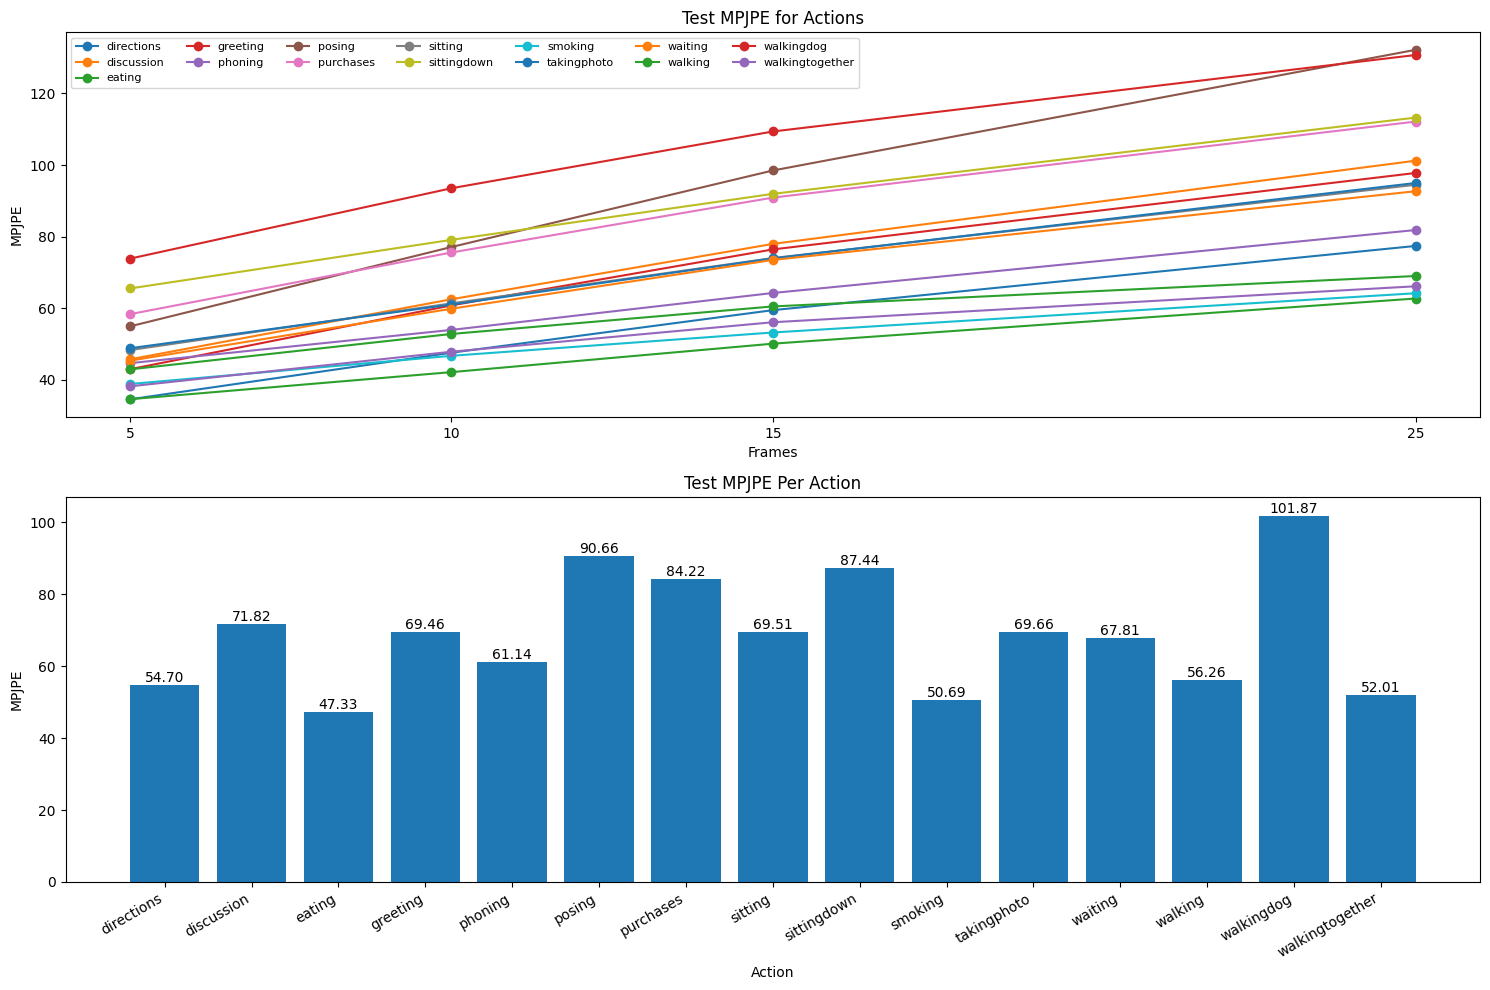

In [ ]:
loss_per_action_per_frame = mpjpe_test_results.groupby(["action", "frames"]).mean().reset_index()
loss_per_action = mpjpe_test_results.groupby(["action"])["loss"].mean().reset_index()

actions = loss_per_action.action.unique()

# using the variable axs for multiple Axes
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs = axs.flatten()

for action in actions:
    loss = loss_per_action_per_frame[loss_per_action_per_frame.action == action]
    axs[0].plot(loss.frames, loss.loss, label=action, marker='o')
    axs[0].set_xticks(loss.frames, loss.frames)

axs[0].legend(ncol=len(actions) / 2, fontsize=8)
axs[0].set_title("Test MPJPE for Actions")
axs[0].set_xlabel("Frames")
axs[0].set_ylabel("MPJPE")

bar = axs[1].bar(actions, loss_per_action.loss)
for rect in bar:
        height = rect.get_height()
        axs[1].text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

axs[1].set_xticks(range(len(actions)), labels=actions, rotation=30, ha='right')
axs[1].set_title("Test MPJPE Per Action")
axs[1].set_ylabel("MPJPE")
axs[1].set_xlabel("Action")

plt.tight_layout()
plt.show()

Here, we show the table of the MPJPE per action.



In [ ]:
display(loss_per_action)

,action,loss
0,directions,54.701005
1,discussion,71.821404
2,eating,47.333771
3,greeting,69.458284
4,phoning,61.135453
5,posing,90.660131
6,purchases,84.220107
7,sitting,69.511889
8,sittingdown,87.439104
9,smoking,50.687286


## Iterative Mechanism (**3 Points**)

In this exercise, you will explore the concept of an iterative mechanism and its adaptability when the model's output length changes. You will start with a model designed to produce 25 output frames but adapt it to generate only 10. The exercise will involve modifying and re-training the model for the new output length. During test time, the model will generate 10 frames and then use them as input to generate the successive 10 frames, and so on, until the desired number of frames is reached. In this case, you are asked to generate 25 frames.

The steps are as follows:
- Change the model's output length from 25 to 10.
- Re-train the model.
- Rewrite the test function to generate 25 frames using the iterative mechanism.
- Generate a new report and compare the results to the baseline model.

In [ ]:
# # Arguments to setup the datasets
datas = 'h36m' # dataset name
path = './data/h3.6m/h3.6m/dataset'
input_n= 10 # number of frames to train on (default=10)

'''
Insert your code below
'''
output_n= 10 # number of frames to predict on

input_dim=3 # dimensions of the input coordinates(default=3)
skip_rate=1 # # skip rate of frames
joints_to_consider=22

#FLAGS FOR THE TRAINING
mode='train' #choose either train or test mode

batch_size_test=8
model_path_iterative= "./checkpoints/iterative/" # path to the model checkpoint file
Path(model_path_iterative).mkdir(exist_ok=True, parents=True)

actions_to_consider_test='all' # actions to test on.
model_name = datas+'_3d_'+str(output_n)+'frames_ckpt' #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz='all' # actions to visualize
visualize_from='test'
n_viz=2


In [ ]:
# Load Data
print('Loading Train Dataset...')
dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=0)
print('Loading Validation Dataset...')
vald_dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=1)

#! Note: Ignore warning:  "VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences"

Loading Train Dataset...


/content/drive/MyDrive/aml-2023/homework-1/Practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


Loading Validation Dataset...


In [6]:
batch_size=256

print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)#

print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

NameError: ignored

In [ ]:
from models.sttr.sttformer import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

n_heads = 1

model = Model(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                 num_channels=3, kernel_size=[3,3], use_pes=True).to(device)

print('total number of parameters of the network is: '+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Using device: cuda
total number of parameters of the network is: 26694


In [ ]:
# Arguments to setup the optimizer
lr=1e-01 # learning rate
use_scheduler=True # use MultiStepLR scheduler
milestones=[10,30]   # the epochs after which the learning rate is adjusted by gamma
gamma=0.1 #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay=1e-05 # weight decay (L2 penalty)
optimizer=optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

clip_grad=None # select max norm to clip gradients
# Argument for training
n_epochs=41
log_step = 200

### Train and Validation Loop

In [ ]:
save_and_plot = True # save the model and plot the loss. Change to True if you want to save the model and plot the loss

[Epoch: 1, Iteration:     1]  training loss: 559.463
[Epoch: 1, Iteration:   201]  training loss: 114.496
[Epoch: 1, Iteration:   401]  training loss: 94.685
[Epoch: 1, Iteration:   601]  training loss: 86.492
[Epoch: 1, Iteration:     1]  validation loss: 83.573
[Epoch: 2, Iteration:     1]  training loss: 85.558
[Epoch: 2, Iteration:   201]  training loss: 73.322
[Epoch: 2, Iteration:   401]  training loss: 68.932
[Epoch: 2, Iteration:   601]  training loss: 67.505
[Epoch: 2, Iteration:     1]  validation loss: 75.902
[Epoch: 3, Iteration:     1]  training loss: 73.604
[Epoch: 3, Iteration:   201]  training loss: 70.278
[Epoch: 3, Iteration:   401]  training loss: 66.396
[Epoch: 3, Iteration:   601]  training loss: 68.145
[Epoch: 3, Iteration:     1]  validation loss: 70.654
[Epoch: 4, Iteration:     1]  training loss: 75.650
[Epoch: 4, Iteration:   201]  training loss: 69.629
[Epoch: 4, Iteration:   401]  training loss: 68.437
[Epoch: 4, Iteration:   601]  training loss: 66.359
[Epo

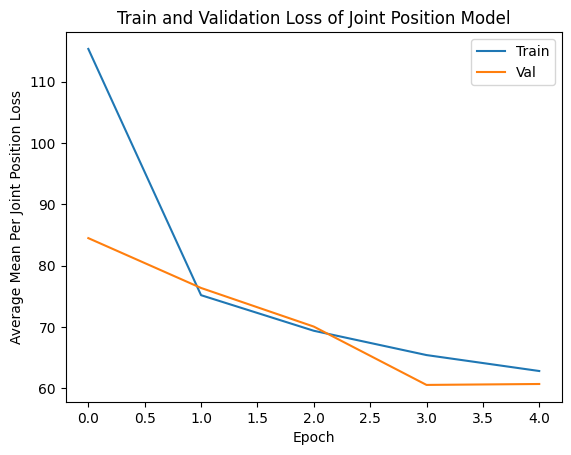

[Epoch: 6, Iteration:     1]  training loss: 62.347
[Epoch: 6, Iteration:   201]  training loss: 58.816
[Epoch: 6, Iteration:   401]  training loss: 61.032
[Epoch: 6, Iteration:   601]  training loss: 58.638
[Epoch: 6, Iteration:     1]  validation loss: 67.925
[Epoch: 7, Iteration:     1]  training loss: 63.622
[Epoch: 7, Iteration:   201]  training loss: 61.313
[Epoch: 7, Iteration:   401]  training loss: 64.822
[Epoch: 7, Iteration:   601]  training loss: 59.943
[Epoch: 7, Iteration:     1]  validation loss: 57.927
[Epoch: 8, Iteration:     1]  training loss: 63.409
[Epoch: 8, Iteration:   201]  training loss: 57.158
[Epoch: 8, Iteration:   401]  training loss: 56.220
[Epoch: 8, Iteration:   601]  training loss: 57.648
[Epoch: 8, Iteration:     1]  validation loss: 58.572
[Epoch: 9, Iteration:     1]  training loss: 56.958
[Epoch: 9, Iteration:   201]  training loss: 54.655
[Epoch: 9, Iteration:   401]  training loss: 58.231
[Epoch: 9, Iteration:   601]  training loss: 55.894
[Epoch

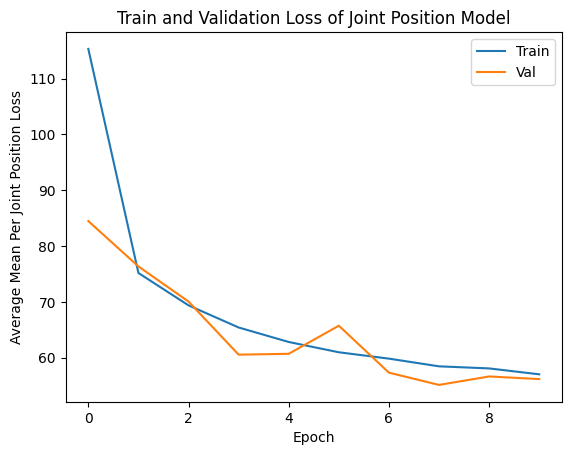

[Epoch: 11, Iteration:     1]  training loss: 57.903
[Epoch: 11, Iteration:   201]  training loss: 54.448
[Epoch: 11, Iteration:   401]  training loss: 51.824
[Epoch: 11, Iteration:   601]  training loss: 55.683
[Epoch: 11, Iteration:     1]  validation loss: 52.079
[Epoch: 12, Iteration:     1]  training loss: 51.805
[Epoch: 12, Iteration:   201]  training loss: 51.708
[Epoch: 12, Iteration:   401]  training loss: 49.839
[Epoch: 12, Iteration:   601]  training loss: 52.268
[Epoch: 12, Iteration:     1]  validation loss: 49.468
[Epoch: 13, Iteration:     1]  training loss: 50.207
[Epoch: 13, Iteration:   201]  training loss: 53.309
[Epoch: 13, Iteration:   401]  training loss: 52.236
[Epoch: 13, Iteration:   601]  training loss: 53.211
[Epoch: 13, Iteration:     1]  validation loss: 49.604
[Epoch: 14, Iteration:     1]  training loss: 51.874
[Epoch: 14, Iteration:   201]  training loss: 52.456
[Epoch: 14, Iteration:   401]  training loss: 51.946
[Epoch: 14, Iteration:   601]  training 

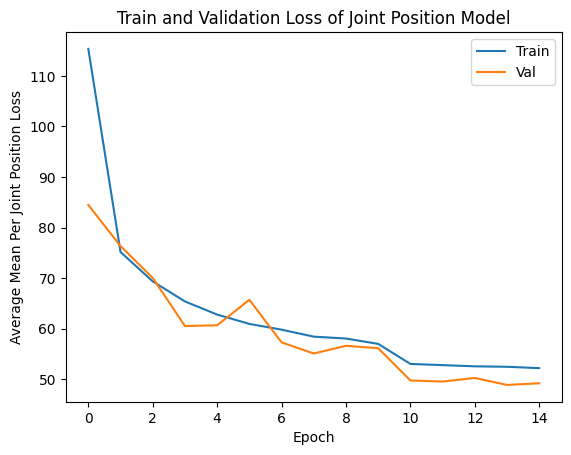

[Epoch: 16, Iteration:     1]  training loss: 51.571
[Epoch: 16, Iteration:   201]  training loss: 51.442
[Epoch: 16, Iteration:   401]  training loss: 48.718
[Epoch: 16, Iteration:   601]  training loss: 54.514
[Epoch: 16, Iteration:     1]  validation loss: 51.581
[Epoch: 17, Iteration:     1]  training loss: 53.440
[Epoch: 17, Iteration:   201]  training loss: 50.853
[Epoch: 17, Iteration:   401]  training loss: 50.459
[Epoch: 17, Iteration:   601]  training loss: 51.649
[Epoch: 17, Iteration:     1]  validation loss: 49.895
[Epoch: 18, Iteration:     1]  training loss: 53.853
[Epoch: 18, Iteration:   201]  training loss: 52.717
[Epoch: 18, Iteration:   401]  training loss: 54.001
[Epoch: 18, Iteration:   601]  training loss: 53.786
[Epoch: 18, Iteration:     1]  validation loss: 51.940
[Epoch: 19, Iteration:     1]  training loss: 52.549
[Epoch: 19, Iteration:   201]  training loss: 50.784
[Epoch: 19, Iteration:   401]  training loss: 52.857
[Epoch: 19, Iteration:   601]  training 

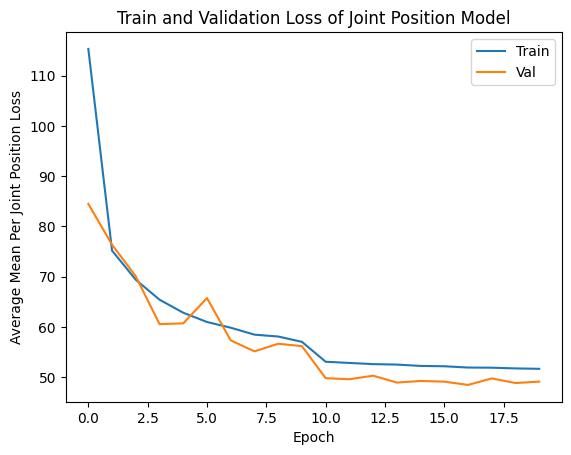

[Epoch: 21, Iteration:     1]  training loss: 48.593
[Epoch: 21, Iteration:   201]  training loss: 54.293
[Epoch: 21, Iteration:   401]  training loss: 52.887
[Epoch: 21, Iteration:   601]  training loss: 53.265
[Epoch: 21, Iteration:     1]  validation loss: 47.980
[Epoch: 22, Iteration:     1]  training loss: 53.806
[Epoch: 22, Iteration:   201]  training loss: 48.673
[Epoch: 22, Iteration:   401]  training loss: 52.940
[Epoch: 22, Iteration:   601]  training loss: 49.010
[Epoch: 22, Iteration:     1]  validation loss: 47.583
[Epoch: 23, Iteration:     1]  training loss: 50.293
[Epoch: 23, Iteration:   201]  training loss: 52.582
[Epoch: 23, Iteration:   401]  training loss: 50.884
[Epoch: 23, Iteration:   601]  training loss: 50.947
[Epoch: 23, Iteration:     1]  validation loss: 49.890
[Epoch: 24, Iteration:     1]  training loss: 46.813
[Epoch: 24, Iteration:   201]  training loss: 50.412
[Epoch: 24, Iteration:   401]  training loss: 50.243
[Epoch: 24, Iteration:   601]  training 

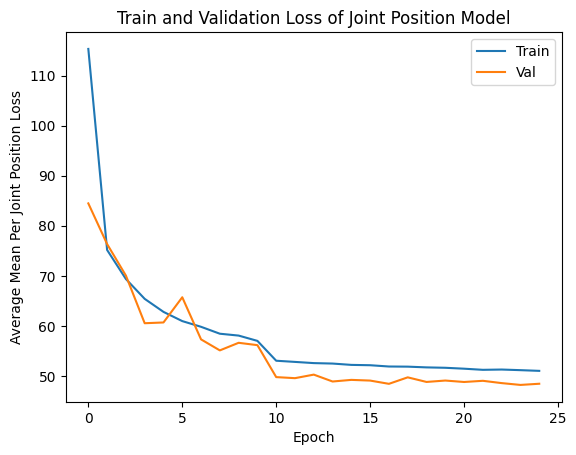

[Epoch: 26, Iteration:     1]  training loss: 51.343
[Epoch: 26, Iteration:   201]  training loss: 49.685
[Epoch: 26, Iteration:   401]  training loss: 50.557
[Epoch: 26, Iteration:   601]  training loss: 48.939
[Epoch: 26, Iteration:     1]  validation loss: 48.194
[Epoch: 27, Iteration:     1]  training loss: 49.521
[Epoch: 27, Iteration:   201]  training loss: 50.415
[Epoch: 27, Iteration:   401]  training loss: 49.362
[Epoch: 27, Iteration:   601]  training loss: 50.581
[Epoch: 27, Iteration:     1]  validation loss: 47.852
[Epoch: 28, Iteration:     1]  training loss: 52.978
[Epoch: 28, Iteration:   201]  training loss: 50.080
[Epoch: 28, Iteration:   401]  training loss: 51.360
[Epoch: 28, Iteration:   601]  training loss: 52.793
[Epoch: 28, Iteration:     1]  validation loss: 45.676
[Epoch: 29, Iteration:     1]  training loss: 50.485
[Epoch: 29, Iteration:   201]  training loss: 50.747
[Epoch: 29, Iteration:   401]  training loss: 52.810
[Epoch: 29, Iteration:   601]  training 

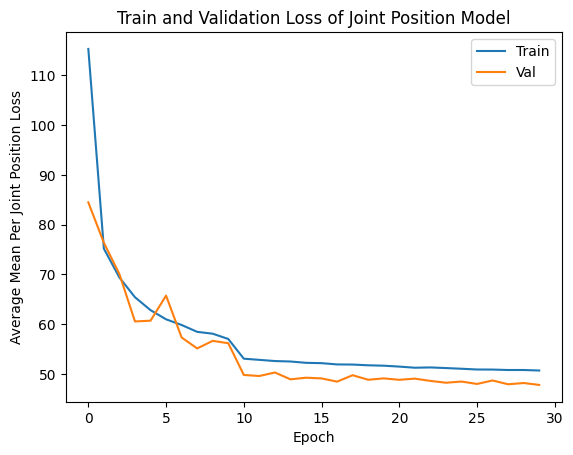

[Epoch: 31, Iteration:     1]  training loss: 48.744
[Epoch: 31, Iteration:   201]  training loss: 47.016
[Epoch: 31, Iteration:   401]  training loss: 50.625
[Epoch: 31, Iteration:   601]  training loss: 52.161
[Epoch: 31, Iteration:     1]  validation loss: 45.508
[Epoch: 32, Iteration:     1]  training loss: 50.453
[Epoch: 32, Iteration:   201]  training loss: 48.676
[Epoch: 32, Iteration:   401]  training loss: 50.276
[Epoch: 32, Iteration:   601]  training loss: 49.293
[Epoch: 32, Iteration:     1]  validation loss: 46.212
[Epoch: 33, Iteration:     1]  training loss: 52.469
[Epoch: 33, Iteration:   201]  training loss: 49.652
[Epoch: 33, Iteration:   401]  training loss: 49.766
[Epoch: 33, Iteration:   601]  training loss: 47.673
[Epoch: 33, Iteration:     1]  validation loss: 48.688
[Epoch: 34, Iteration:     1]  training loss: 48.875
[Epoch: 34, Iteration:   201]  training loss: 48.437
[Epoch: 34, Iteration:   401]  training loss: 54.831
[Epoch: 34, Iteration:   601]  training 

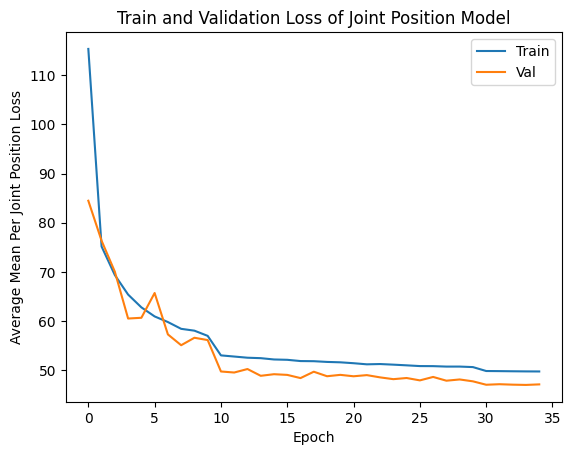

[Epoch: 36, Iteration:     1]  training loss: 49.360
[Epoch: 36, Iteration:   201]  training loss: 50.067
[Epoch: 36, Iteration:   401]  training loss: 47.645
[Epoch: 36, Iteration:   601]  training loss: 50.242
[Epoch: 36, Iteration:     1]  validation loss: 48.641
[Epoch: 37, Iteration:     1]  training loss: 48.066
[Epoch: 37, Iteration:   201]  training loss: 49.820
[Epoch: 37, Iteration:   401]  training loss: 45.916
[Epoch: 37, Iteration:   601]  training loss: 50.620
[Epoch: 37, Iteration:     1]  validation loss: 46.171
[Epoch: 38, Iteration:     1]  training loss: 47.837
[Epoch: 38, Iteration:   201]  training loss: 49.057
[Epoch: 38, Iteration:   401]  training loss: 46.614
[Epoch: 38, Iteration:   601]  training loss: 50.801
[Epoch: 38, Iteration:     1]  validation loss: 49.081
[Epoch: 39, Iteration:     1]  training loss: 52.247
[Epoch: 39, Iteration:   201]  training loss: 47.188
[Epoch: 39, Iteration:   401]  training loss: 49.768
[Epoch: 39, Iteration:   601]  training 

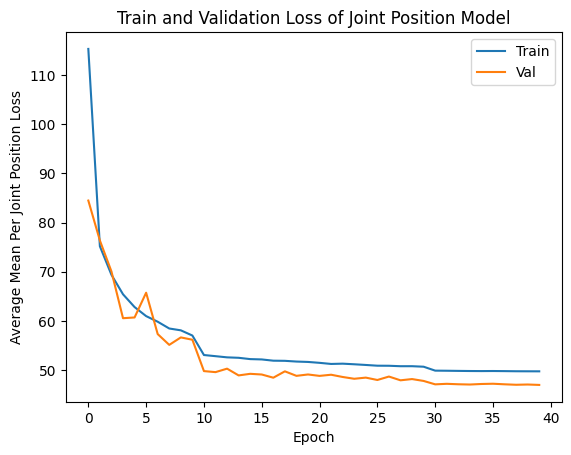

In [ ]:
# launch training with the new output_n
train(data_loader, vald_loader, path_to_save_model=model_path_iterative)

### Test Loop

In [ ]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,25,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]


          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)


          sequences_gt=batch[:, input_n:input_n+output_n, :]


          running_time = time.time()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
          #sequences_predict = model(sequences_train)
          totalll += time.time()-running_time
          counter += 1
          '''
          Insert your code below. You will need to iteratively predict the next frames and feed it to back to the model until you reach the desired number of frames.
          '''



          sequences_gt = sequences_gt[:,:,dim_used].view(-1,output_n,len(dim_used)//3,3)


          loss = mpjpe_error(sequences_predict ,sequences_gt)

          for i in range(2):
            if i == 0:
              sequences_gt= batch[:, 20:30, dim_used].view(-1,output_n,len(dim_used)//3,3)

              sequences_predict = sequences_predict.permute(0,3,1,2)

              sequences_predict = model(sequences_predict).view(-1, output_n, joints_to_consider, 3)

              loss += mpjpe_error(sequences_predict, sequences_gt )

            else:

              sequences_gt= batch[:, 30:35, dim_used].view(-1,output_n//2,len(dim_used)//3,3)

              sequences_predict = sequences_predict.permute(0,3,1,2)

              sequences_predict = model(sequences_predict).view(-1, output_n, joints_to_consider, 3)

              loss += mpjpe_error(sequences_predict[:,:5,:,:], sequences_gt )
            running_loss += loss
      print(f'{action} loss = {running_loss/n}')




[TODO] Compare w/ the other model

In [ ]:
test(ckpt_path= f"{model_path_iterative}model_params_epoch_39.pt")

model loaded


/content/drive/MyDrive/aml-2023/homework-1/Practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


walking loss = 43.44565200805664
eating loss = 40.17087936401367
smoking loss = 42.54434585571289
discussion loss = 59.51579284667969
directions loss = 51.517433166503906
greeting loss = 68.39869689941406
phoning loss = 52.18822479248047
posing loss = 79.77529907226562
purchases loss = 67.09918212890625
sitting loss = 63.396183013916016
sittingdown loss = 79.63240814208984
takingphoto loss = 61.4761962890625
waiting loss = 56.51544189453125
walkingdog loss = 75.68478393554688
walkingtogether loss = 42.783775329589844


## YOUR custom model (**3 Points**)
 In this exercise, you will implement a Transformer-like network (based on the Theory notebook) for this specific task. You can use the Transformer's Encoder and implement your own Decoder to predict future poses. (e.g. RNN, MLP, CNN, TCN, ...).
 We won't provide any code for this exercise, but you can use the code provided in the Theory notebook as a starting point.
 The goal of this exercise is not to beat the previous model but to understand how to implement a Transformer network for this specific task. For this reason, the evaluation will be based on the code you write and the explanation you provide in the report rather than the results.


### Performance BONUS (**Up to 2 Points**)
- **1 Bonus Point** if the model achieves an A-MPJPE between 80 and 90 millimeters.
- **2 Bonus Points** if the model achieves an A-MPJPE between 70 and 80 millimeters.


In [12]:
'''
Input Shape: [batch_size, input_time, joints, 3]

Encoder:
Input shape: [batch_size, input_time, joints, 3]
Output shape: [batch_size, input_time/output_time, joints, FREE]

# Decoder:
Input shape: [batch_size, input_time/output_time, joints, FREE]
Output shape: [batch_size, output_time, joints, 3]


Hint: Transformers often take an input of shape [batch_size, time, joints*channels], use the reshape or view function to match the dimensionality.
'''

'\nInput Shape: [batch_size, input_time, joints, 3]\n\nEncoder:\nInput shape: [batch_size, input_time, joints, 3]\nOutput shape: [batch_size, input_time/output_time, joints, FREE]\n\n# Decoder:\nInput shape: [batch_size, input_time/output_time, joints, FREE]\nOutput shape: [batch_size, output_time, joints, 3]\n\n\nHint: Transformers often take an input of shape [batch_size, time, joints*channels], use the reshape or view function to match the dimensionality.\n'

In [58]:
class Attention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, attn_dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, query, key, value, mask=None):

        '''
        add here the code regarding the argument of the softmax function as defined above
        '''
        # the dimensionality of the key vectors. it's the number of columns since the matrices are stacked row vectors.
        key_dim = key.shape[-1]

        # compute attention, dot product between query and keys, divided by sqrt of the key vector dimensionality
        attn = torch.matmul(query, torch.transpose(key, -2, -1)) # Changed with matrix moltiplication from torch so no problems with batches
        attn /= torch.sqrt(torch.tensor(key_dim))


        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))

        '''
        Computed attn, calculate the final output of the attention layer
        '''

        # after the softmax, we just multiply by the value to get the output
        output = torch.matmul(attn, value)

        return output, attn

In [59]:
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, d_model, dropout=0.1):
        """
        Take in model size and number of heads.
        """
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        #  We assume d_v always equals d_k
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.query_ff = nn.Linear(d_model, d_model)
        self.key_ff = nn.Linear(d_model, d_model)
        self.value_ff = nn.Linear(d_model, d_model)
        self.attn_ff = nn.Linear(d_model, d_model)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.attention = Attention(attn_dropout=dropout)

    def forward(self, query, key, value, mask=None, return_attention=False):

        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k.
        # The query is given as example, you should do the same for key and value
        query = self.query_ff(query).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        '''
        Add your code below
        '''
        key = self.key_ff(key).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.value_ff(value).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)

        # 2) Apply attention on all the projected vectors in batch.
        '''
        Add your code below
        '''
        # we want to compute the attention for each head that we have.
        # the 1st dimension is the batch dimension, so there are no problems since we have broadcasting with torch
        x = self.attention.forward(query, key, value)[0]

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.num_heads * self.d_k)

        if return_attention:
            return self.attn_ff(x), self.attn

        return self.attn_ff(x)


In [67]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiHeadAttention(num_heads, input_dim)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self_attention part (use self.norm1)
        multi_head_attn = self_attn.forward(x, x, x, mask=mask)
        multi_head_attn = self.dropout(multi_head_attn)
        normed = self.norm1(x + multi_head_attn)

        # MLP part (use self.norm2)
        ffn_out = self.linear_net.forward(normed)
        ffn_out = self.dropout(ffn_out)
        normed = self.norm2(x + ffn_out)

        x = normed

        return x

In [68]:
class DecoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Self Attention layer
        self.self_attn = MultiHeadAttention(num_heads, input_dim)
        # Attention Layer
        self.src_attn = MultiHeadAttention(num_heads, input_dim)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.norm3 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, src_mask, tgt_mask):
        # Self-Attention part (use self.norm1)

        masked_attn, *_ = self.self_attn.forward(x, x, x, mask=tgt_mask)
        masked_attn = self.dropout(masked_attn)
        normed = self.norm1(x + masked_attn)

        # Attention part (use self.norm2)
        # Recall that memory is the output of the encoder and replaces x as
        # the key and value in the attention layer

        attn = self.src_attn.forward(normed, memory, memory, mask=src_mask)
        attn = self.dropout(attn)
        normed = self.norm2(normed + attn)

        # MLP part (use self.norm3)
        linear_out = self.linear_net.forward(normed)
        linear_out = self.dropout(linear_out)
        x = self.norm3(normed + linear_out)

        return x

In [69]:
class PositionalEncoding(nn.Module):
    """
    Implement the PE function.
    """

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)

        # --------- start of our code

        # all possible positions
        positions = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)

        # getting the even dimensions
        even_dims = torch.arange(0, d_model, 2, dtype=torch.float32)

        # getting the odd dimensions
        odd_dims = torch.arange(1, d_model, 2, dtype=torch.float32)

        # calculating the denominators
        sin_denominator = torch.pow(10000.0, even_dims / d_model)
        cos_denominator = torch.pow(10000.0, (odd_dims - 1) / d_model)

        # assigning the sin output to the even dimensions
        pe[:, 0::2] = torch.sin(positions / sin_denominator)

        # assigning the cos output to the odd dimensions
        pe[:, 1::2] = torch.cos(positions / cos_denominator)

        # ------- end of our code

        pe = pe.unsqueeze(0) # the final dimension is (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

In [70]:
class Transformer(nn.Module):
    def __init__(self, enc_inp_size, dec_inp_size, dec_out_size, N=6,
                   d_model=512, dim_feedforward=2048, num_heads=8, dropout=0.1,
                   mean=[0,0],std=[0,0]):
        super(Transformer, self).__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.N = N
        self.mean = mean
        self.std = std
        self.enc_inp_size = enc_inp_size
        self.dec_inp_size = dec_inp_size
        self.dec_out_size = dec_out_size

        self.encoder = nn.ModuleList([deepcopy(
            EncoderBlock(d_model, num_heads, dim_feedforward, dropout)) for _ in range(N)])
        self.decoder = nn.ModuleList([deepcopy(
            DecoderBlock(d_model, num_heads, dim_feedforward, dropout)) for _ in range(N)])
        self.pos_enc = PositionalEncoding(d_model, dropout)
        self.pos_dec = PositionalEncoding(d_model, dropout)
        self.src_embed = nn.Linear(enc_inp_size, d_model)
        self.tgt_embed = nn.Linear(dec_inp_size, d_model)
        self.out = nn.Linear(d_model, dec_out_size)

        self.init_weights()


    def forward(self, src, trg, src_mask, trg_mask):

        # First part of the forward pass: embedding and positional encoding
        # both for the source and target

        # ------ our code start
        src_embed = self.src_embed.forward(src)
        src_x = self.pos_enc(src_embed)

        target_embed = self.tgt_embed.forward(trg)
        target_x = self.pos_dec(target_embed)

        # ------ our code end

        # Second part of the forward pass: the encoder and decoder layers.
        # Look at the arguments of the forward pass of the encoder and decoder
        # and recall that the encoder output is used as the memory in the decoder.

        # ------ our code start

        for i in range(self.N):
          src_x = self.encoder[i].forward(src_x)

        for j in range(self.N):
          target_x = self.decoder[j].forward(x=target_x, memory=src_x, src_mask=src_mask, tgt_mask=trg_mask)

        output = self.out.forward(target_x)
        output = F.softmax(output, dim=-1)
        # ------ our code end

        return output


    # Initialize parameters with Glorot / fan_avg.
    def init_weights(self):
        for p in self.encoder.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.decoder.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.pos_enc.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.pos_dec.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.src_embed.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.tgt_embed.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.out.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)

In [101]:
# Select GPU device for the training if available
if not torch.cuda.is_available():
     device=torch.device("cpu")
     print("Current device:", device)
else:
     device=torch.device("cuda")
     print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))

enc_input_size = 66
dec_input_size = 66
dec_output_size = 66


num_heads = 6
d_model = 66
dim_feedforward = 2048
dropout = 0.1
preds_num = 8

def subsequent_mask(size):
    """
    Mask out subsequent positions.
    """
    attn_shape = (1, size, size)
    mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(mask) == 0

torch.manual_seed(0)
tf = Transformer(enc_input_size, dec_input_size, dec_output_size, N=6,
            d_model=d_model, dim_feedforward=dim_feedforward,
            num_heads=num_heads, dropout=dropout).to(device)

Current device: cuda - Type: Tesla T4


In [108]:
def train(data_loader,vald_loader, path_to_save_model=None):
  train_loss = []
  val_loss = []
  val_loss_best = 1000

  dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                    46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                    75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

  for epoch in range(n_epochs-1):
      running_loss=0
      n=0
      tf.train()
      for cnt,batch in enumerate(data_loader):
          batch=batch.float().to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)).to(device)
          #print("seq_train", sequences_train.shape)
          target = batch[:, input_n:input_n+output_n, dim_used].view(-1, output_n, len(dim_used)).to(device)
          #print("target" , target.shape)


          optimizer.zero_grad()


          start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 22).to(device)
          #print("start_of_seq",start_of_seq.shape)
          #target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
          # Final decoder input is the concatenation of them along temporal dimension
          dec_inp = torch.cat((start_of_seq, target), 1).to(device)



          src_att = torch.ones((sequences_train.shape[0], 1, sequences_train.shape[1])).to(device)

          trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)




          sequences_predict = tf.forward(sequences_train, target, trg_mask= trg_att, src_mask =src_att).view(-1, output_n, joints_to_consider, 3).to(device)


          #sequences_predict = tf.forward(sequences_train , target , src_att , trg_att).view(-1, output_n, joints_to_consider, 3)



          loss = mpjpe_error(sequences_predict,target)

          if cnt % log_step == 0:
            print('[Epoch: %d, Iteration: %5d]  training loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))
            '''
            for name, param in tf.named_parameters():
                  print(f"Parameter name: {name}, Shape: {param.shape}")
                  print(f"Parameter values:\n{param.data}\n")
            '''
          loss.backward()
          if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(tf.parameters(),clip_grad)

          optimizer.step()
          running_loss += loss*batch_dim

      train_loss.append(running_loss.detach().cpu()/n)

      tf.eval()

      with torch.no_grad():
          running_loss=0
          n=0
          for cnt,batch in enumerate(vald_loader):
              batch=batch.float().to(device)
              batch_dim=batch.shape[0]
              n+=batch_dim

              sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)).to(device)
              #print("seq_train", sequences_train.shape)
              target = batch[:, input_n:input_n+output_n, dim_used].view(-1, output_n, len(dim_used)).to(device)

              start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 22).to(device)
              #print("start_of_seq",start_of_seq.shape)
              #target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
              # Final decoder input is the concatenation of them along temporal dimension
              dec_inp = torch.cat((start_of_seq, target), 1).to(device)

              src_att = torch.ones((sequences_train.shape[0], 1, sequences_train.shape[1])).to(device)

              trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)

              sequences_predict = tf.forward(sequences_train, target, trg_mask= trg_att, src_mask =src_att).view(-1, output_n, joints_to_consider, 3).to(device)

              loss = mpjpe_error(sequences_predict,target)

              if cnt % log_step == 0:
                print('[Epoch: %d, Iteration: %5d]  validation loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))

              running_loss += loss*batch_dim

          val_loss.append(running_loss.detach().cpu()/n)

          if running_loss/n < val_loss_best:
            val_loss_best = running_loss/n

      if use_scheduler:
        scheduler.step()

      '''
      Insert your code below. Use the argument path_to_save_model to save the model to the path specified.
      '''

      def plot_loss(train_loss, val_loss):
        """Plots the training and validation loss curves of the model.

        The loss curves will be plotted in the same plot, with a legend annotating the curves.
        The epochs axis will start from 0, not 1 like the print statements in the loop.

        :arg
          train_loss (iterable): the per epoch training loss of the model.
          val_loss (iterable): the per epoch validation loss of the model.
        """
        plt.xlabel("Epoch")
        plt.ylabel("Average Mean Per Joint Position Loss")
        plt.title("Train and Validation Loss of Joint Position Model")
        plt.plot(train_loss, label="Train")
        plt.plot(val_loss, label="Val")
        plt.legend()
        plt.show()

      # save and plot model every 5 epochs
      # epoch + 1 so that we don't print after the first epoch and also save and plot after the last epoch
      if save_and_plot:
        if (epoch + 1) % 5 == 0 or (epoch == n_epochs - 2):
            full_param_path = f"{path_to_save_model}model_params_epoch_{epoch}.pt"

            # saves and loads only the model parameters:
            torch.save(tf.state_dict(), full_param_path)
            print(f"Model saved at: {full_param_path}")

            # plot
            plot_loss(train_loss, val_loss)

In [ ]:
save_and_plot = False
optimizer=optim.Adam(tf.parameters(), lr=lr, weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
train(data_loader,vald_loader)


[Epoch: 1, Iteration:     1]  training loss: 560.108
[Epoch: 1, Iteration:   201]  training loss: 558.210
[Epoch: 1, Iteration:   401]  training loss: 557.276
[Epoch: 1, Iteration:   601]  training loss: 557.273
[Epoch: 1, Iteration:     1]  validation loss: 574.808
[Epoch: 2, Iteration:     1]  training loss: 559.305
[Epoch: 2, Iteration:   201]  training loss: 556.138
[Epoch: 2, Iteration:   401]  training loss: 556.204


In [104]:
self_attn = MultiHeadAttention(num_heads, d_model).to(device)
